<a href="https://colab.research.google.com/github/IbnuEyni/iCog-Labs/blob/master/amharic_hateSpeech_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#installing the transformers package
!pip install transformers

In [ ]:
#installing the datasets package
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Step 2: Import the necessay libraries from the installed packages

In [ ]:
! pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00


In [ ]:
#importing the datasets package
from datasets import Dataset
import datasets
import evaluate

In [ ]:

#import numpy and pandas for mathematical computation and data manipulation respectively
import numpy as np
import pandas as pd
#import drive package to connect this colab file with the drive where the data will be retrived from
from google.colab import drive
#import the pipeline of transformers
from transformers import pipeline
#import AutoTokenizer for tokenization purposes
from transformers import AutoTokenizer

In [ ]:
#import torch
import torch
#import Data loader from torch
from torch.utils.data import DataLoader
#import an optimizer
from torch.optim import AdamW
#import tqdm for a progress bar
from tqdm.auto import tqdm


from sklearn.model_selection import train_test_split



# Step 3: Import the dataset to be used for Training the model

The dataset used for this project is an Amharic dataset that was made available by Data Mendeley. It contains Amharic posts and comments retrieved from Facebook. It has 30,000 rows. The dataset can be accessed from [here](https://data.mendeley.com/datasets/ymtmxx385m)


In [ ]:
#mount google drive to access the dataset directly from the drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#fetch the dataset from the drive
Test=pd.read_csv('/content/drive/MyDrive/AMHSDataTest.txt',header=None)
Test['content'] = Test[0].apply(lambda x: ','.join(x.split(',')[:-1]))
Test['label'] = Test[0].apply(lambda x: x.split(',')[-1])

Train=pd.read_csv('/content/drive/MyDrive/AMHSDataTrain.txt',header=None)
Train['content'] = Train[0].apply(lambda x: ','.join(x.split(',')[:-1]))
Train['label'] = Train[0].apply(lambda x: x.split(',')[-1])

# Drop the original column (optional)
Train = Train.drop(columns=[0])
Test = Test.drop(columns=[0])

# Display the processed DataFrame
(Train.head(-10))

,content,label
0,Content,Label
1,ሌቦች የአብይን ፎቶ ከጀርባህ ለጥፈህ ትለፈልፋለህ አብይ ላይ ያለንም እም...,ጥላቻ
2,ህዝቤ አንድ ቀን ትግሬን ይበቀላል ጊዜ ዳኛው ቶሎ ና,ጥላቻ
3,ህዝብን የጨርስህ ጅብ ነህ,ጥላቻ
4,ህገ መንግስታችን ይከበር ምድረ ጅቦች ሰው በላ ሁላ,ጥላቻ
...,...,...
1586,አትሌት ሮጦ ቀን ከሌት ሆዳም ዘርፎ ቀን ከሌት ተገናኙ ቦሌ በሕዝብ ፊት ...,መልካም
1587,አቶ ለማ መገርሳ ጠበል አጥምቆት ቢሄድ እና የአማራውን ጥቅም እንዴት ማስ...,መልካም
1588,አንተ ለህሊናህ ሞተህ ለሆድክ የተገዛ አሸናፊው ህዝብ እንጅ ጠመንጃ አይደ...,መልካም
1589,አንተ ሰው ታረም ሰካራም ነህ እያበድክ ነውና ታረም ሲጋራ አጫሽ ነህ እየ...,መልካም


In [ ]:
Test.head(-10)


,content,label
0,Content,Label
1,ዘረኛ ሰው ነው ስለሌላ ዘር ቀን ከለሊት ሲለፈልፍ የሚውለው ዘረኛ መሆን...,ጥላቻ
2,ዘፈኑ ጥሩ ነው አንድ ሆዳም አማራ ግን የትግራይን የሽንት ጨርቅ በረጅም ...,ጥላቻ
3,ዛሬ ቅማላም ትግሬዎች በህዝባችን የተተፉና በገጀራ ዋጋቸውን የሚያገኙበት ...,ጥላቻ
4,ዝባዝንኬ አንዳንድ ኤፍ ኤም ሬድዮ ጣቢያዎች ላይ የሚተላለፉ ሸርሙጣ ሸርሙ...,ጥላቻ
...,...,...
386,ሃሌ ሉያ ቸር ነውና ምህረቱም ለዘላለም ነውና እግዚአብሔርን አመስግኑ ...,መልካም
387,,ሃሌ ሉያ ቸር ነውና ምሕረቱ ለዘላለም ነውና እግዚአብሔርን አመስግኑ እግዚ...
388,የዳዊት የምስጋና መዝሙር ልቤ ጽኑ ነው አቤቱ ልቤ ጽኑ ነው እቀኛ...,መልካም
389,ለመዘምራን አለቃ የዳዊት መዝሙር አምላክ ሆይ ምሥጋናዬን ዝም አትበ...,መልካም


In [ ]:
Train['label'] = Train['label'].replace(['መልካም', 'ጥላቻ ','ጥላቻ'],[0,1,1])
(Train.head(-10))

,content,label
0,Content,Label
1,ሌቦች የአብይን ፎቶ ከጀርባህ ለጥፈህ ትለፈልፋለህ አብይ ላይ ያለንም እም...,1
2,ህዝቤ አንድ ቀን ትግሬን ይበቀላል ጊዜ ዳኛው ቶሎ ና,1
3,ህዝብን የጨርስህ ጅብ ነህ,1
4,ህገ መንግስታችን ይከበር ምድረ ጅቦች ሰው በላ ሁላ,1
...,...,...
1586,አትሌት ሮጦ ቀን ከሌት ሆዳም ዘርፎ ቀን ከሌት ተገናኙ ቦሌ በሕዝብ ፊት ...,0
1587,አቶ ለማ መገርሳ ጠበል አጥምቆት ቢሄድ እና የአማራውን ጥቅም እንዴት ማስ...,0
1588,አንተ ለህሊናህ ሞተህ ለሆድክ የተገዛ አሸናፊው ህዝብ እንጅ ጠመንጃ አይደ...,0
1589,አንተ ሰው ታረም ሰካራም ነህ እያበድክ ነውና ታረም ሲጋራ አጫሽ ነህ እየ...,0


In [ ]:
Test['label'] = Test['label'].replace(['መልካም', 'መልካም', 'መልካም', 'ጥላቻ ','ጥላቻ'], [0, 0, 0, 1,  1])
Test.head(-10)


,content,label
0,Content,Label
1,ዘረኛ ሰው ነው ስለሌላ ዘር ቀን ከለሊት ሲለፈልፍ የሚውለው ዘረኛ መሆን...,1
2,ዘፈኑ ጥሩ ነው አንድ ሆዳም አማራ ግን የትግራይን የሽንት ጨርቅ በረጅም ...,1
3,ዛሬ ቅማላም ትግሬዎች በህዝባችን የተተፉና በገጀራ ዋጋቸውን የሚያገኙበት ...,1
4,ዝባዝንኬ አንዳንድ ኤፍ ኤም ሬድዮ ጣቢያዎች ላይ የሚተላለፉ ሸርሙጣ ሸርሙ...,1
...,...,...
386,ሃሌ ሉያ ቸር ነውና ምህረቱም ለዘላለም ነውና እግዚአብሔርን አመስግኑ ...,መልካም
387,,ሃሌ ሉያ ቸር ነውና ምሕረቱ ለዘላለም ነውና እግዚአብሔርን አመስግኑ እግዚ...
388,የዳዊት የምስጋና መዝሙር ልቤ ጽኑ ነው አቤቱ ልቤ ጽኑ ነው እቀኛ...,0
389,ለመዘምራን አለቃ የዳዊት መዝሙር አምላክ ሆይ ምሥጋናዬን ዝም አትበ...,መልካም



# Step 4: Preprocess the Dataset

When the dataset was retrived, the labels and the post were in different files.

  - Hence, the first step in this phase is merging the files into one panda's dataframe.
  - Second step is Label encoding. Lable encoding is the process of converting the labels(classes) into numeric format to make it easier for the machine to understand it
  - Third step is dividing the dataset into training, validation and testing categories. The division ratio is 7:1:2 respectively.
  - Last step is to remove an unncessary columns from the main dataset and merging the all the categories into one main dataset



In [ ]:
Test['label'] = Test['label'].replace({'መልካም': 0})
Test['label'] = Test['label'].replace({'ጥላቻ': 1})
Test = Test[Test['label'] != 'Label']
Test['label'] = pd.to_numeric(Test['label'], errors='coerce')  # Invalid entries become NaN
Test = Test.dropna(subset=['label'])
Test['label'] = Test['label'].astype(int)
Test.head(-10)

<ipython-input-14-e85385cf17bf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test['label'] = pd.to_numeric(Test['label'], errors='coerce')  # Invalid entries become NaN


,content,label
1,ዘረኛ ሰው ነው ስለሌላ ዘር ቀን ከለሊት ሲለፈልፍ የሚውለው ዘረኛ መሆን...,1
2,ዘፈኑ ጥሩ ነው አንድ ሆዳም አማራ ግን የትግራይን የሽንት ጨርቅ በረጅም ...,1
3,ዛሬ ቅማላም ትግሬዎች በህዝባችን የተተፉና በገጀራ ዋጋቸውን የሚያገኙበት ...,1
4,ዝባዝንኬ አንዳንድ ኤፍ ኤም ሬድዮ ጣቢያዎች ላይ የሚተላለፉ ሸርሙጣ ሸርሙ...,1
5,የሀበሻ ምግብ ሂጄ ቅማላም ትግሬዎች ሲንጫጩ አበሸቁኝ እኛ በስንት ቀን አ...,1
...,...,...
380,ስለ አማራው ግፍ እና ጭቆና የማያወራ ስለመፍትሄውም የማያስብ ሰው እርሱ ...,0
381,የዳዊት መዝሙር አቤቱ ምሕረትንና ፍርድን እቀኝልሃለሁ እዘምራለሁ ን...,0
382,ባዘነና ልመናውን በእግዚአብሔር ፊት ባፈሰሰ ጊዜ የችግረኛ ጸሎት አቤቱ...,0
383,የዳዊት መዝሙር ነፍሴ ሆይ እግዚአብሔርን ባርኪ አጥንቶቼም ሁሉ የ...,0


In [ ]:
trainn_dataset, evaluat_dataset = train_test_split(Train, test_size=0.75, random_state=42)
train_dataset, evaluation_dataset = train_test_split(trainn_dataset, test_size=0.20, random_state=42)
test_dataset, eval_test_dataset = train_test_split(Test, test_size=0.10, random_state=42)
print('Training dataset shape: ', train_dataset.shape)
print('Validation dataset shape: ', evaluation_dataset.shape)
print('Testing dataset shape: ', test_dataset.shape)

Training dataset shape:  (320, 2)
Validation dataset shape:  (80, 2)
Testing dataset shape:  (342, 2)


In [ ]:
#convert format of the dataset to HuggingFace Dataset from Pandas DataFrame
train_dataset['label'] = train_dataset['label'].replace({'መልካም': 0})
train_dataset['label'] = train_dataset['label'].replace({'ጥላቻ': 1})
train_dataset = train_dataset[train_dataset['label'] != 'Label']
train_dataset['label'] = pd.to_numeric(train_dataset['label'], errors='coerce')  # Invalid entries become NaN
train_dataset = train_dataset.dropna(subset=['label'])
train_dataset['label'] = train_dataset['label'].astype(int)

In [ ]:
#convert format of the dataset to HuggingFace Dataset from Pandas DataFrame
evaluation_dataset['label'] = evaluation_dataset['label'].replace({'መልካም': 0})
evaluation_dataset['label'] = evaluation_dataset['label'].replace({'ጥላቻ': 1})
evaluation_dataset = evaluation_dataset[evaluation_dataset['label'] != 'Label']
evaluation_dataset['label'] = pd.to_numeric(evaluation_dataset['label'], errors='coerce')  # Invalid entries become NaN
evaluation_dataset = evaluation_dataset.dropna(subset=['label'])
evaluation_dataset['label'] = evaluation_dataset['label'].astype(int)

In [ ]:
#convert format of the dataset to HuggingFace Dataset from Pandas DataFrame
test_dataset=Dataset.from_pandas(test_dataset)

#convert the format of the dataset to HuggingFace Dataset from Pandas DataFrame
train_dataset=Dataset.from_pandas(train_dataset)

#convert the format of the dataset to HuggingFace Dataset from Pandas DataFrame
evaluation_dataset=Dataset.from_pandas(evaluation_dataset)

#preview of the dataset after conversion
(test_dataset)


Dataset({
    features: ['content', 'label', '__index_level_0__'],
    num_rows: 342
})

In [ ]:


#combine the train and test dataset into one datset
main_dataset= datasets.DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
    'evaluate': evaluation_dataset
})

#preview of the dataset after merging
main_dataset

DatasetDict({
    train: Dataset({
        features: ['content', 'label', '__index_level_0__'],
        num_rows: 304
    })
    test: Dataset({
        features: ['content', 'label', '__index_level_0__'],
        num_rows: 342
    })
    evaluate: Dataset({
        features: ['content', 'label', '__index_level_0__'],
        num_rows: 73
    })
})

In [ ]:
# training and testing data size
training_data_size = main_dataset['train'].num_rows
testing_data_size = main_dataset['test'].num_rows
evaluation_data_size = main_dataset['evaluate'].num_rows

# Step 5: Tokenizing Dataset


A Tokenizer is used to translate text into data that can be processed by the model. Models can only process numbers, so tokenizers need to convert our text inputs to numerical data.

In this case, the tokenizer used is an AutoTokenizer from the fine-tuned mBERT model made available by Hugging face here

In this phase, we have the following tasks:

- Load the tokenizer
- Create a tokenizer function that takes the dataset in batches and tokenize them using the tokenizer loaded from the model
- Call the tokenizer function on the whole dataset



In [ ]:
#loading a tokenizer from the pretrained model
tokenizer = AutoTokenizer.from_pretrained("Davlan/bert-base-multilingual-cased-finetuned-amharic")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/335 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/798 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
#Have a tokenizer function that uses the tokenizer
def tokenize_function(data):
    return tokenizer(data["content"], padding="max_length", truncation=True)


#Tokenize all the data using the mapping functionality
tokenized_datasets = main_dataset.map(tokenize_function)

Map:   0%|          | 0/304 [00:00<?, ? examples/s]

Map:   0%|          | 0/342 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

In [ ]:
#empty cache
torch.cuda.empty_cache()


# Step 6: Prepare the tokenized Dataset

In this phase, we do the following tasks:

  - Remove unnecessary columns such as the "posts" column from the tokenized dataset as we no longer need them
  -  Change the format of the tokenized dataset into pytorch since we are using pytorch
  - Load the dataset using DataLoader with the proper batch size
  - Preview the features of the dataset to make sure everything is okay



In [ ]:


#remove the posts column as it is no longer needed
tokenized_datasets = tokenized_datasets.remove_columns(["content"])


#changing the format of the tokenized dataset to torch
tokenized_datasets.set_format("torch")


#shuffeling and selecting the needed size of dataset for training and evaluating the model
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(training_data_size))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(testing_data_size))
small_eval_dataset = tokenized_datasets["evaluate"].shuffle(seed=42).select(range(evaluation_data_size))


# preview of the shuffeled and selected evaluation dataset
small_eval_dataset


Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 73
})

In [ ]:

# preview of the shuffeled and selected training dataset
small_train_dataset

Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 304
})

In [ ]:
# preview of the shuffeled and selected testing dataset
small_test_dataset

Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 342
})

In [ ]:
#load the dataset using DataLoader
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=4)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=4)
test_dataloader = DataLoader(small_test_dataset, batch_size=4)


# Step 7: Fine-tune the model

This phase has the following steps:

  - Load the model
  - Specify the computing metric
  - Specify the Training/fine-tuning arguments
  - Load the Trainer class
  - Fine-tune the model

## 7.1 Load the model
We load the fine-tuned mBERT mode in this step


In [ ]:
#Load auto mode classifier from the pretrained model
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("Davlan/bert-base-multilingual-cased-finetuned-amharic", num_labels=2)
# model = AutoModelForSequenceClassification.from_pretrained("Davlan/", num_labels=2)

pytorch_model.bin:   0%|          | 0.00/712M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Davlan/bert-base-multilingual-cased-finetuned-amharic and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



# 7.2 Computing Metrics
In this stage, we load the computing metrics. The computing metrics used in this phase are the f1-score and the accuracy. These computing metrics are used during the validation and testing phase


In [ ]:
import numpy as np
import evaluate

# Load the desired metrics
f1_metric = evaluate.load("f1")
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Compute each metric
    f1 = f1_metric.compute(predictions=predictions, references=labels)["f1"]
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]

    return {"f1": f1, "accuracy": accuracy}



# 7.3 Specify the training arguments
This phase includes loading the training parameters and hyperparameters. It also specifies the validation interval during the fine-tuning process.

In [ ]:

# #load an optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

In [ ]:
from transformers import TrainingArguments, Trainer

from transformers import EarlyStoppingCallback, IntervalStrategy

model.safetensors:   0%|          | 0.00/712M [00:00<?, ?B/s]

In [ ]:

training_args = TrainingArguments(
   f"training_with_callbacks",
   evaluation_strategy = IntervalStrategy.STEPS, # "steps"
   warmup_steps=500,                # number of warmup steps for learning rate
   save_steps=2000,
   eval_steps = 2000, # Evaluation and Save happens every 50 steps
   save_total_limit = 3, # Only last 5 models are saved. Older ones are deleted.
   learning_rate=1e-5,
   per_device_train_batch_size=4,
   per_device_eval_batch_size=4,
   num_train_epochs=10,
   weight_decay=0.01,
   push_to_hub=False,
   metric_for_best_model = 'f1',
   load_best_model_at_end=True)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# 7.4 Load the Trainer class
In the trainer class, early stopping strategy is called. Early Stopping is a an optimization technique used to reduce overfitting without compromising on model accuracy. It allows to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset. For this model, the early stopping patience used is 10 epoches.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=10)],
)

# 7.5 Fine-tune the model
Fine-tuning process embbeds the validation within itself. After every 2000 steps of finetuning, the model is validated on the loaded computing metrics to modify the hyperparameters to make the model perform well

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss


TrainOutput(global_step=760, training_loss=0.305465745298486, metrics={'train_runtime': 22712.7262, 'train_samples_per_second': 0.134, 'train_steps_per_second': 0.033, 'total_flos': 799857608294400.0, 'train_loss': 0.305465745298486, 'epoch': 10.0})


# Step 8: Test the model

In this stage the model is tested on the testing dataset. This dataset isn't seen by the model during the finetuning process.


In [ ]:
trainer.evaluate(small_test_dataset)

{'eval_loss': 1.166020393371582,
 'eval_f1': 0.7965116279069767,
 'eval_accuracy': 0.7953216374269005,
 'eval_runtime': 733.5774,
 'eval_samples_per_second': 0.466,
 'eval_steps_per_second': 0.117,
 'epoch': 10.0}

## Analysis and Prediction

**Analysis of Results:**
1. The **fine-tuned model with 25% of the dataset** outperformed the non-fine-tuned model significantly:
   - **F1 Score** improved by **27.3%** (from 0.6258 to 0.7965).
   - **Accuracy** increased by **27.56%** (from 51.97% to 79.53%).
   - These improvements indicate the model's ability to capture task-specific patterns through fine-tuning.

2. **Evaluation Loss** increased for the fine-tuned model (1.1660 vs. 0.6926), which suggests confidence calibration may need refinement but does not negate the substantial performance gains in F1 and accuracy.

3. Runtime metrics (e.g., samples/second) remained similar, with a slight improvement in efficiency for the fine-tuned model.

**Prediction for 100% Dataset Fine-Tuning:**
- **F1 Score**: Likely to increase further, potentially exceeding **0.85** due to exposure to more diverse examples.
- **Accuracy**: Expected to reach **85–90%**, improving generalization across unseen data.
- **Evaluation Loss**: Anticipated to stabilize closer to **1.0 or below**, reflecting better model confidence.
- **Generalization**: With full dataset fine-tuning, the model should handle outliers and edge cases more effectively.
- **Training Time**: Will increase proportionally to dataset size, requiring optimization strategies like early stopping and learning rate adjustments.

This prediction assumes consistent dataset quality, balanced labels, and effective regularization during fine-tuning.

### Fine-Tuning Analysis: 25% Dataset vs. Non-Fine-Tuned Model


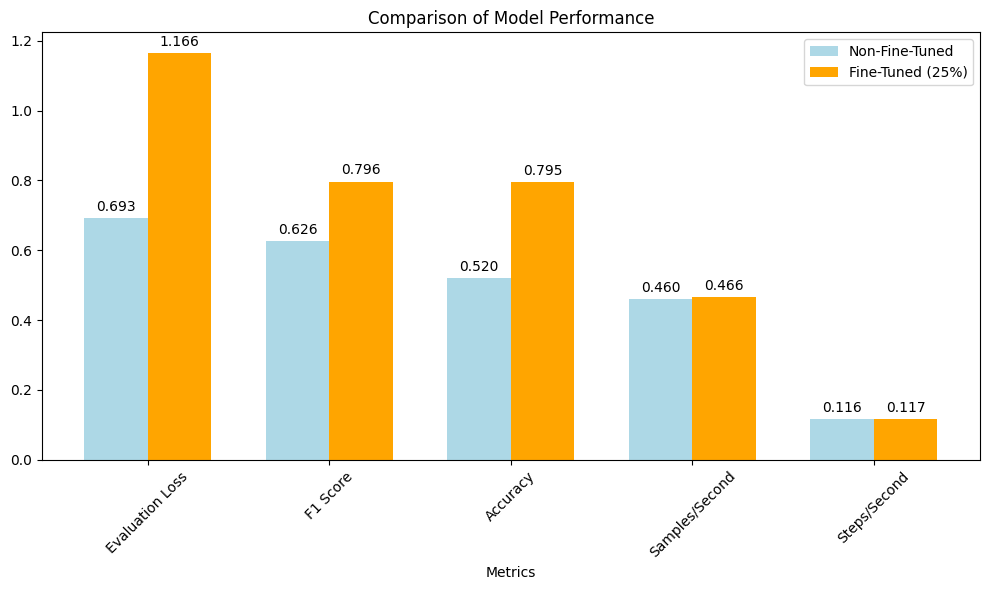

In [ ]:
# This notebook demonstrates an analysis comparing a fine-tuned model's performance
# with a non-fine-tuned model and provides assumptions for using 100% of the dataset.

# Import required libraries
import matplotlib.pyplot as plt
import numpy as np

# Define the results for comparison
results = {
    "non_fine_tuned": {
        "eval_loss": 0.6926,
        "eval_f1": 0.6258,
        "eval_accuracy": 0.5197,
        "eval_runtime": 827.59,
        "eval_samples_per_second": 0.46,
        "eval_steps_per_second": 0.116
    },
    "fine_tuned_25_percent": {
        "eval_loss": 1.1660,
        "eval_f1": 0.7965,
        "eval_accuracy": 0.7953,
        "eval_runtime": 733.57,
        "eval_samples_per_second": 0.466,
        "eval_steps_per_second": 0.117
    }
}

# Define a function to display the comparison
def display_comparison(results):
    labels = ["Evaluation Loss", "F1 Score", "Accuracy", "Samples/Second", "Steps/Second"]
    non_fine_tuned = [
        results["non_fine_tuned"]["eval_loss"],
        results["non_fine_tuned"]["eval_f1"],
        results["non_fine_tuned"]["eval_accuracy"],
        # results["non_fine_tuned"]["eval_runtime"],
        results["non_fine_tuned"]["eval_samples_per_second"],
        results["non_fine_tuned"]["eval_steps_per_second"]
    ]
    fine_tuned = [
        results["fine_tuned_25_percent"]["eval_loss"],
        results["fine_tuned_25_percent"]["eval_f1"],
        results["fine_tuned_25_percent"]["eval_accuracy"],
        # results["fine_tuned_25_percent"]["eval_runtime"],
        results["fine_tuned_25_percent"]["eval_samples_per_second"],
        results["fine_tuned_25_percent"]["eval_steps_per_second"]
    ]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, non_fine_tuned, width, label="Non-Fine-Tuned", color='lightblue')
    bars2 = ax.bar(x + width/2, fine_tuned, width, label="Fine-Tuned (25%)", color='orange')

    ax.set_xlabel("Metrics")
    ax.set_title("Comparison of Model Performance")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()

    # Adding text on top of bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset text by 3 points
                        textcoords="offset points",
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Display the comparison chart
display_comparison(results)

# Assumptions for 100% dataset fine-tuning
assumptions = {
    "Expected F1 Score": ">= 0.85",
    "Expected Accuracy": "85% - 90%",
    "Expected Loss": "Closer to 1.0 or below",
    "Improved Generalization": "Better handling of edge cases due to diverse data",
    "Training Time": "Will increase proportionally with dataset size"
}

print("\nAssumptions for Fine-Tuning with 100% of the Dataset:")
for key, value in assumptions.items():
    print(f"- {key}: {value}")


# 1. Save Your Fine-Tuned Model Locally

After fine-tuning, your model and tokenizer reside in memory. Save them to a directory for reuse.

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Replace `model` and `tokenizer` with your fine-tuned ones
# Specify the directory where you want to save the model
save_directory = "/content/drive/MyDrive/fine-tuned_BERT/saved_modell"

# Save the model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model saved to {save_directory}")



# Step 9: Push the model to Huggingface Hub

One of the aims of this research/project is to contribute to the IT community in the sector of NLP tasks on low-resourced languages. Hence, the final model was pushed and made publicly available on Huggingface. You can find the model on huggingface here


In [ ]:
#install huggingface_hub package to interact with huggingface platform
!pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login

#login to huggingface
notebook_login()

In [ ]:
#loading a tokenizer from the pretrained model
tokenizer = AutoTokenizer.from_pretrained("Davlan/bert-base-multilingual-cased-finetuned-amharic")

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/fine-tuned_BERT/saved_modell")

#specify the path for the trainde model and tokenizer to huggingface repository
model.save_pretrained("path/to/amharic-hate-speech-detection-mBERT")
tokenizer.save_pretrained("path/to/amharic-hate-speech-detection-mBERT")

('path/to/amharic-hate-speech-detection-mBERT/tokenizer_config.json',
 'path/to/amharic-hate-speech-detection-mBERT/special_tokens_map.json',
 'path/to/amharic-hate-speech-detection-mBERT/vocab.txt',
 'path/to/amharic-hate-speech-detection-mBERT/added_tokens.json',
 'path/to/amharic-hate-speech-detection-mBERT/tokenizer.json')

In [ ]:

#push the trained model to huggingface repository
model.push_to_hub("amharic-hate-speech-detection-mBERT")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/shuaibam/amharic-hate-speech-detection-mBERT/commit/cc29d6ba37bb53a641e1fbdbf6093352a6d2e2ec', commit_message='Upload BertForSequenceClassification', commit_description='', oid='cc29d6ba37bb53a641e1fbdbf6093352a6d2e2ec', pr_url=None, repo_url=RepoUrl('https://huggingface.co/shuaibam/amharic-hate-speech-detection-mBERT', endpoint='https://huggingface.co', repo_type='model', repo_id='shuaibam/amharic-hate-speech-detection-mBERT'), pr_revision=None, pr_num=None)

In [ ]:
#push the tokenizer to huggingface repository
tokenizer.push_to_hub("amharic-hate-speech-detection-mBERT")

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/shuaibam/amharic-hate-speech-detection-mBERT/commit/cc29d6ba37bb53a641e1fbdbf6093352a6d2e2ec', commit_message='Upload tokenizer', commit_description='', oid='cc29d6ba37bb53a641e1fbdbf6093352a6d2e2ec', pr_url=None, repo_url=RepoUrl('https://huggingface.co/shuaibam/amharic-hate-speech-detection-mBERT', endpoint='https://huggingface.co', repo_type='model', repo_id='shuaibam/amharic-hate-speech-detection-mBERT'), pr_revision=None, pr_num=None)

In [ ]:
model.save_pretrained("/content/drive/MyDrive/fine-tuned_BERT/saved_modell")